In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from ipynb.fs.full.UtilCollections import POSITIONS
from ipynb.fs.full.UtilFunctions import format_season

In [59]:
def run_kmeans_per_season(season):
    #Pre processed df for player data in a given season
    df = pre_process(range(season, season+1))
    
    clusters_range = range(5,15)
    data = df.loc[:, ~df.columns.isin(["Player", "Pos", "Tm"])]
    data = data.values.tolist()
    #Define best number of clusters K
    plot_elbow_method(data, clusters_range)
    silhouette_avg = plot_silhouette_method(data, clusters_range)
    num_clusters = np.argmax(silhouette_avg)+5

    #Run kmeans and save each player's cluster
    df["Cluster"] = run_kmeans(data, num_clusters)
    print_clusters(df, num_clusters)
    
    #Find distribution of each position in a cluster
    position_percentages = find_position_distribution(df, num_clusters)
    plot_position_distribution(position_percentages, num_clusters, True)

In [61]:
def run_kmeans_multiple_seasons(seasons):
    #Pre processed df for player data in a given season
    df = pre_process(seasons)
    
    clusters_range = range(5,15)
    data = df.loc[:, ~df.columns.isin(["Player", "Pos", "Tm"])]
    data = data.values.tolist()
    #Define best number of clusters K
    plot_elbow_method(data, clusters_range)
    silhouette_avg = plot_silhouette_method(data, clusters_range)
    num_clusters = np.argmax(silhouette_avg)+5

    #Run kmeans and save each player's cluster
    df["Cluster"] = run_kmeans(data, num_clusters)
    print_clusters(df, num_clusters)
    
    #Find distribution of each position in a cluster
    position_percentages = find_position_distribution(df, num_clusters)
    plot_position_distribution(position_percentages, num_clusters, True)

In [2]:
def pre_process(seasons):
    df = None
    for season in seasons:
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        if season > 1997:
            shooting_data = pd.read_csv(f"DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_{first_year}-{second_year}.csv")
            player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])

        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data.sort_values(by=['G'], ascending=False)
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
        player_data.reset_index(inplace=True)
        player_data.drop(columns=['index'], inplace=True)
        player_data["Player"] = player_data["Player"] + " - " + str(season)
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    return df

In [22]:
def plot_elbow_method(data, clusters_range):
    inertias = []

    for i in clusters_range:
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=15)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    plt.plot(clusters_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

In [26]:
def plot_silhouette_method(data, clusters_range):
    silhouette_avg = []
    for n in clusters_range: 
        kmeans = KMeans(n_clusters=n, random_state=42, n_init=15)
        kmeans.fit(data)
        cluster_labels = kmeans.labels_
        silhouette_avg.append(silhouette_score(data, cluster_labels))

    plt.plot(clusters_range,silhouette_avg,'bx-')
    plt.grid()
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score')
    plt.title('Silhouette analysis For Optimal k')
    plt.show()
    return silhouette_avg

In [37]:
def run_kmeans(data, clusters):
    kmeans = KMeans(n_clusters=clusters, random_state=42, n_init=15)
    kmeans.fit(data)
    return kmeans.labels_

In [51]:
def print_clusters(df, n):
    for i in range(n):
        print("Cluster",i)
        print(df[df['Cluster'] == i].head(10)[['Player']])
        print()

In [6]:
def find_position_distribution(df, clusters):
    clustered_df = df.groupby(["Cluster", "Pos"]).count()[["Player"]]
    for i, row in clustered_df.iterrows():
        clustered_df.loc[i, "Position%"] = row['Player'] / clustered_df.loc[i[0]].sum()['Player']
    position_percentages = {}

    for p in POSITIONS:
        position_percentages[p] = []

    for i in range(clusters):
        cluster = clustered_df.loc[i]
        for p in POSITIONS:
            if p in list(cluster.index):
                position_percentages[p].append(cluster.loc[p]['Position%'])
            else:
                position_percentages[p].append(0)
    
    return position_percentages

In [7]:
def plot_position_distribution(pp, clusters, print_numbers=False, fig_name="PlayerDistribution"):
    fig, ax = plt.subplots(figsize=(20, 12), dpi=80)

    counter = np.zeros(clusters)

    for position in POSITIONS:
        ax.bar(range(clusters), pp[position], bottom=counter, label=position)
        counter += np.array(pp[position])

    if print_numbers:
        for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_y() + (bar.get_height() * 0.45), 
                    round(bar.get_height(),2), 
                    ha='center', color='black', weight='bold', size=12)

    ax.set_xlabel("Cluster", fontsize=18)
    ax.set_ylabel("% of position in the cluster", fontsize=18)
    ax.set_xticks(range(clusters))
    ax.legend(loc='center left', bbox_to_anchor=(0.95, 0.5),
              fancybox=True, shadow=True, ncol=1, prop={'size': 15})
    plt.savefig(f"Results/Clustering/{fig_name}.jpg", bbox_inches='tight')
    plt.show()

## Run kmeans algorithm for each season since 2017

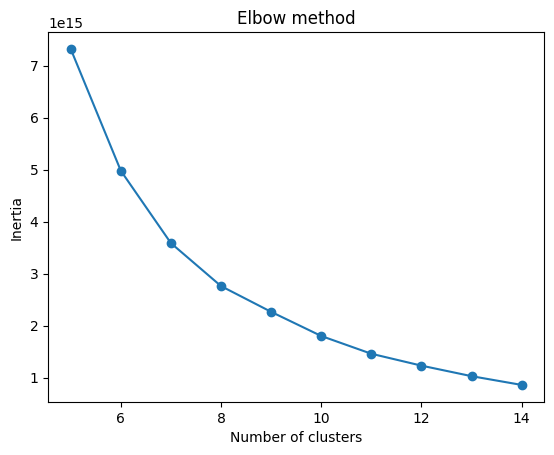

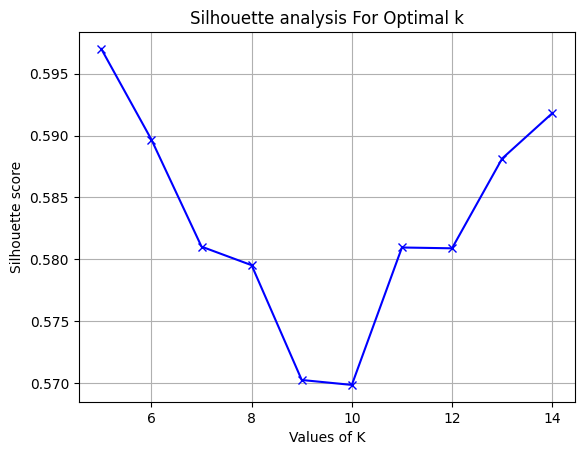

Cluster 0
                       Player
3       Andrew Wiggins - 2017
7          Jeff Teague - 2017
13  Karl-Anthony Towns - 2017
21           Ish Smith - 2017
30         Cory Joseph - 2017
36        Trevor Ariza - 2017
41     Otto Porter Jr. - 2017
47      Brandon Ingram - 2017
65       Jonas Jerebko - 2017
69        Jaylen Brown - 2017

Cluster 1
                       Player
17   Russell Westbrook - 2017
23        James Harden - 2017
24      Andre Drummond - 2017
27      DeAndre Jordan - 2017
53     Harrison Barnes - 2017
73        Bradley Beal - 2017
75    Hassan Whiteside - 2017
80       Nicolas Batum - 2017
97       Anthony Davis - 2017
102     Damian Lillard - 2017

Cluster 2
                        Player
1        Justin Holiday - 2017
2            Joe Ingles - 2017
4          Gorgui Dieng - 2017
5     Marreese Speights - 2017
8         Elfrid Payton - 2017
9          Jamal Murray - 2017
10      Marquese Chriss - 2017
15          Rudy Gobert - 2017
19  Dorian Finney-Smith - 201

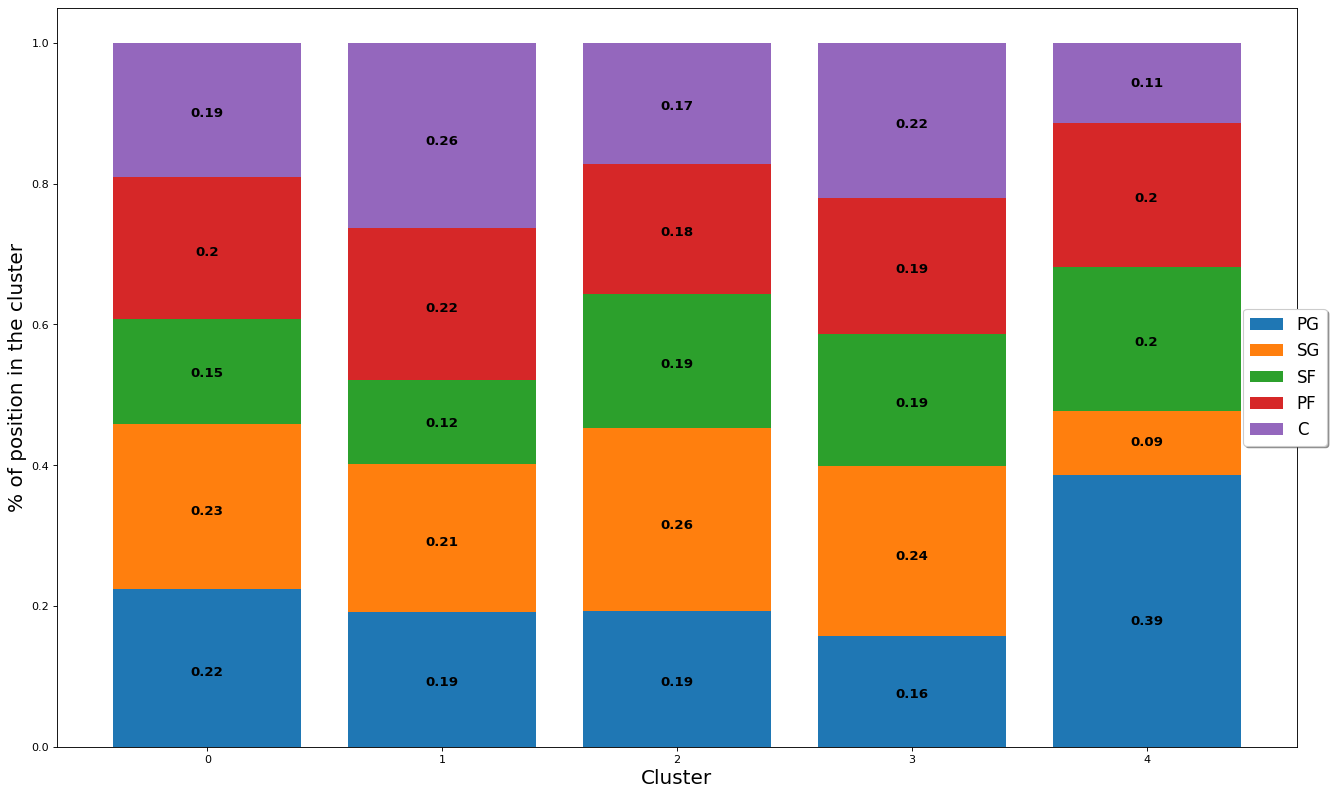

In [62]:
run_kmeans_multiple_seasons(range(2017, 2023))

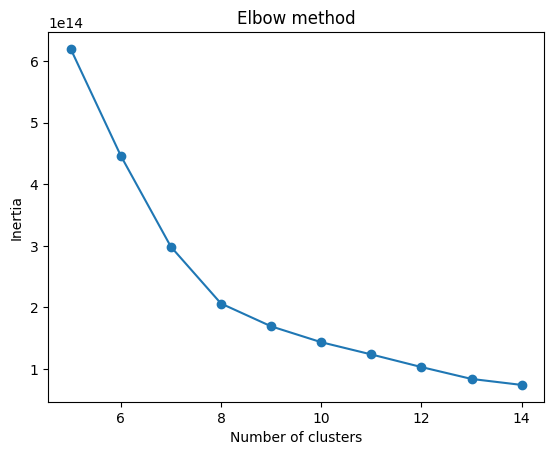

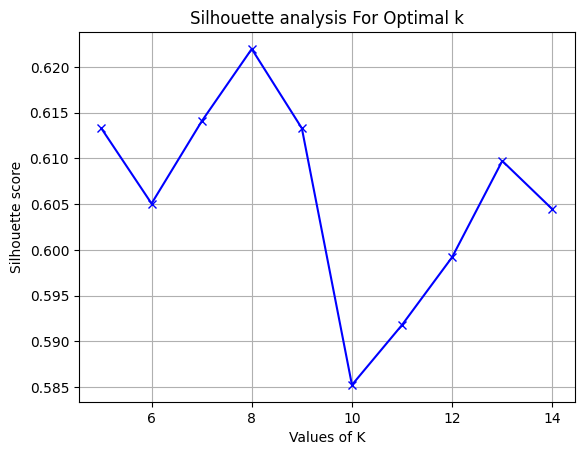

Cluster 0
                      Player
6       Tobias Harris - 2017
14    Bismack Biyombo - 2017
16        Greg Monroe - 2017
50       Allen Crabbe - 2017
62   Tristan Thompson - 2017
64      Klay Thompson - 2017
68          John Wall - 2017
88       Jimmy Butler - 2017
92     Draymond Green - 2017
108       Paul George - 2017

Cluster 1
                     Player
2         Joe Ingles - 2017
4       Gorgui Dieng - 2017
8      Elfrid Payton - 2017
9       Jamal Murray - 2017
10   Marquese Chriss - 2017
15       Rudy Gobert - 2017
22      Myles Turner - 2017
26  Domantas Sabonis - 2017
29       CJ McCollum - 2017
31      Steven Adams - 2017

Cluster 2
                           Player
0            Marcin Gortat - 2017
11         Jordan Clarkson - 2017
12          Jamal Crawford - 2017
18             Robin Lopez - 2017
25  Michael Kidd-Gilchrist - 2017
35            Amir Johnson - 2017
40            Solomon Hill - 2017
44            Kemba Walker - 2017
46           Stephen Curry - 2017
6

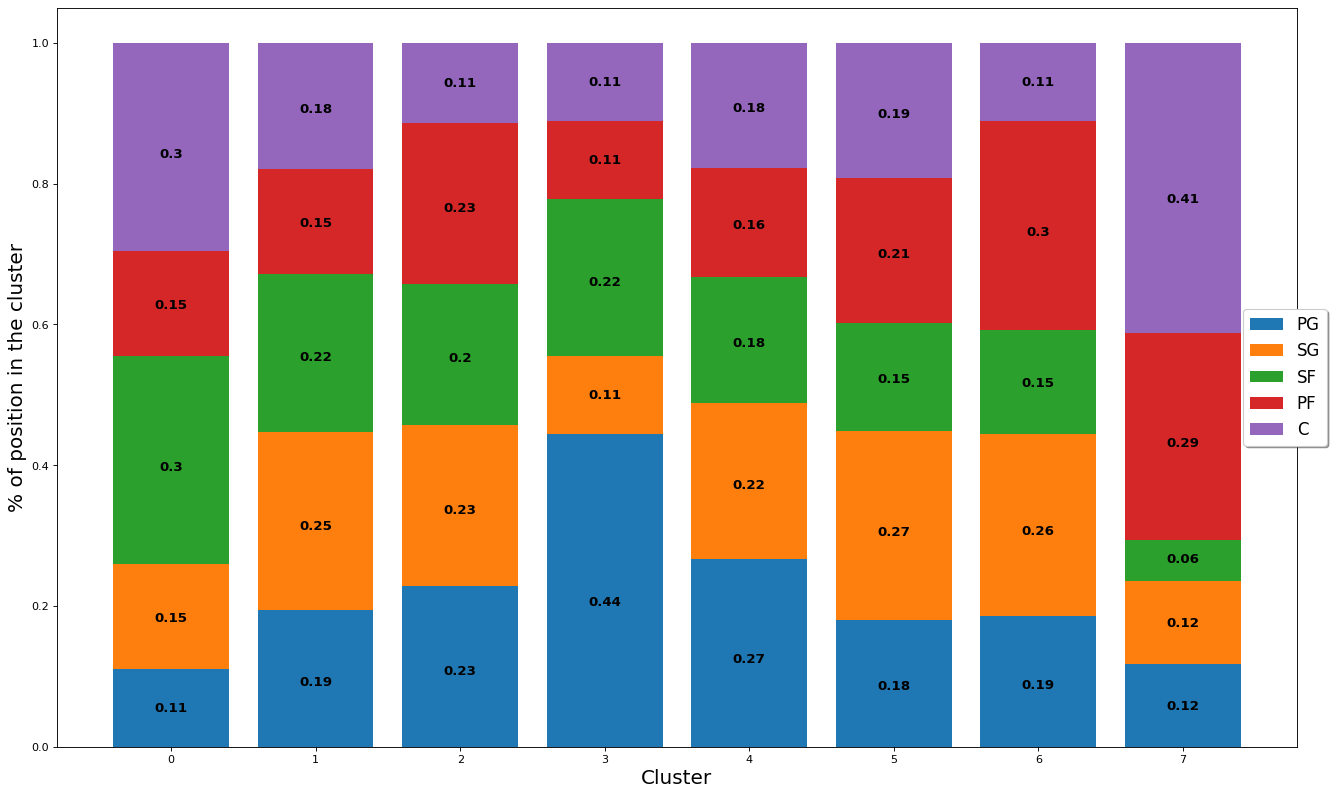

In [60]:
#2017
run_kmeans_per_season(2017)

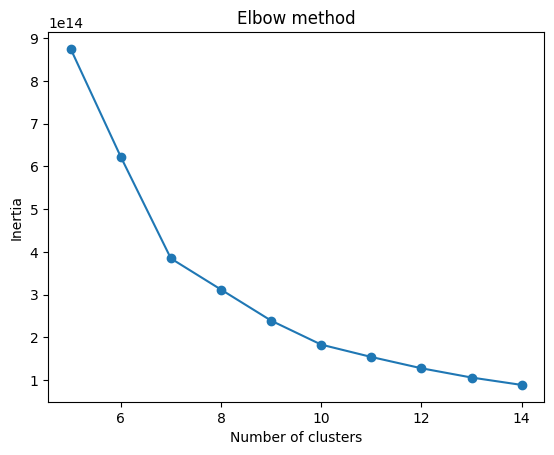

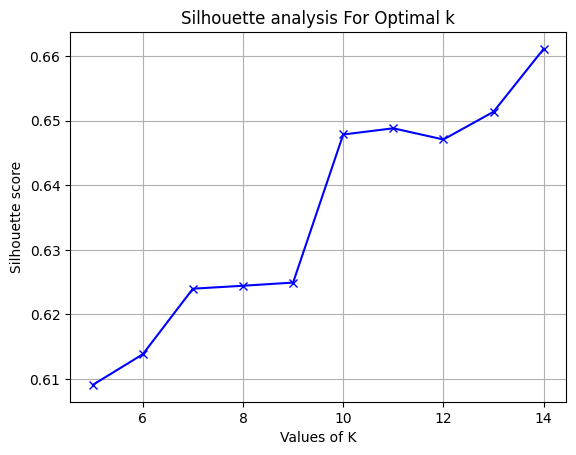

Cluster 0
                      Player
0    Lance Stephenson - 2018
1        LeBron James - 2018
34        Aron Baynes - 2018
41         J.R. Smith - 2018
49   Bojan Bogdanović - 2018
55       Jusuf Nurkić - 2018
64         Joe Harris - 2018
65  Bogdan Bogdanović - 2018
67         Jeff Green - 2018
68        Dario Šarić - 2018

Cluster 1
                              Player
9             Bismack Biyombo - 2018
57                Evan Turner - 2018
61                Paul George - 2018
98               Allen Crabbe - 2018
112  Kentavious Caldwell-Pope - 2018
137             Klay Thompson - 2018
141             Tyler Johnson - 2018
149              Enes Freedom - 2018
153            Draymond Green - 2018
157               Jeff Teague - 2018

Cluster 2
                      Player
6         Patty Mills - 2018
8       E'Twaun Moore - 2018
28    Josh Richardson - 2018
40   Robert Covington - 2018
54      Dwight Powell - 2018
96         Tony Snell - 2018
127   Markieff Morris - 2018
146      K

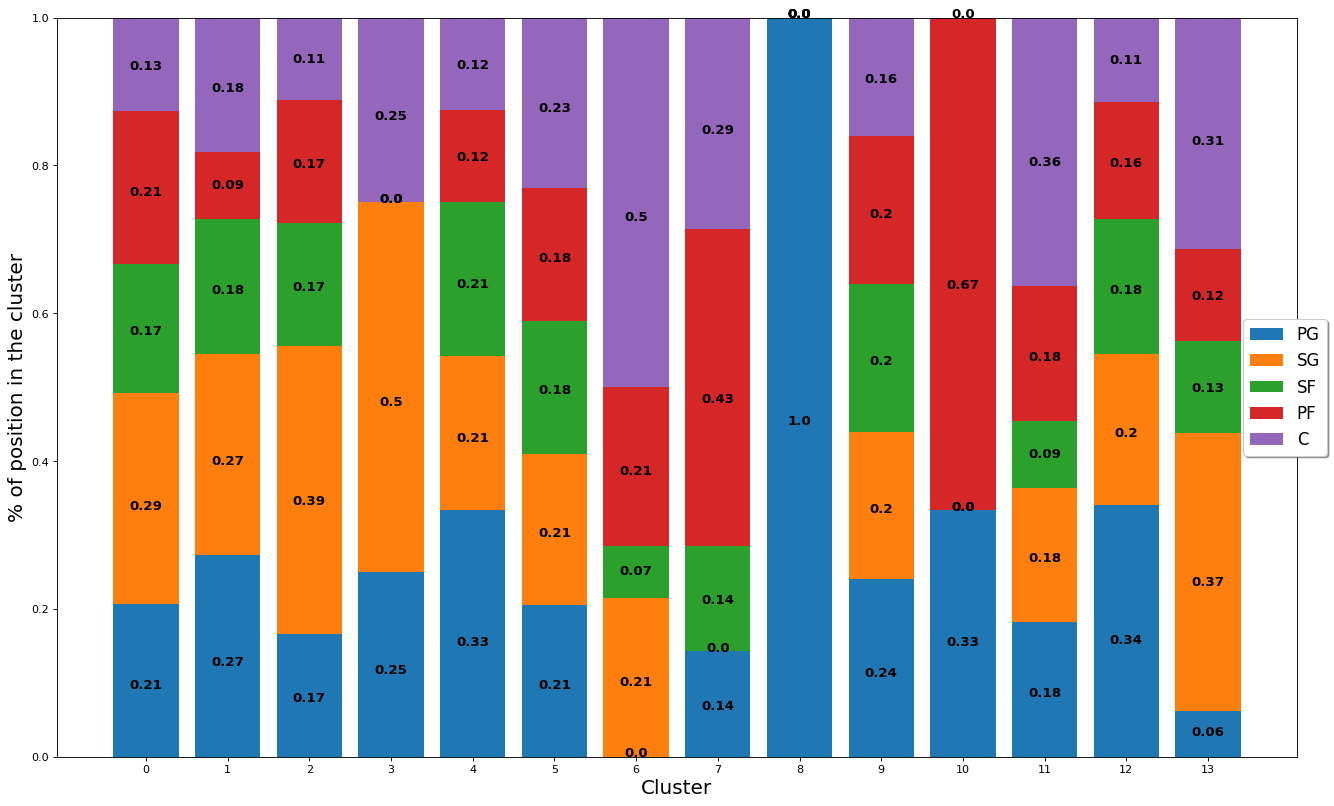

In [54]:
#2018
run_kmeans_per_season(2018)

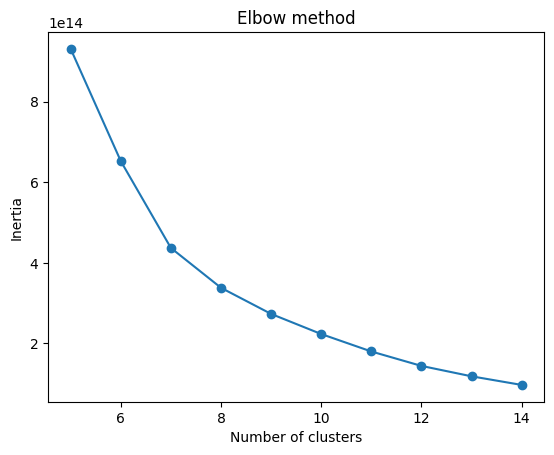

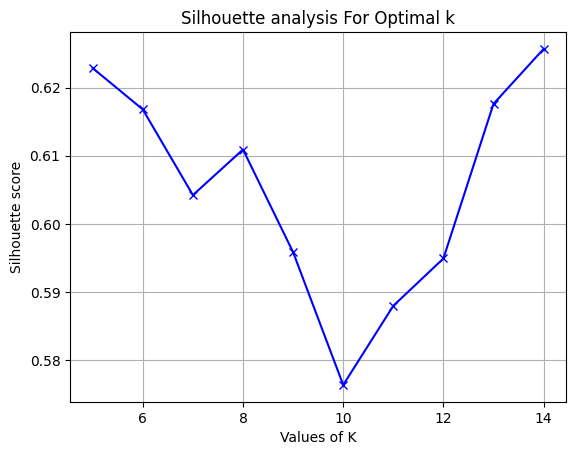

Cluster 0
                              Player
0                  Joe Ingles - 2019
5    Kentavious Caldwell-Pope - 2019
10                Patty Mills - 2019
14               Kemba Walker - 2019
18              Mason Plumlee - 2019
31            Jordan Clarkson - 2019
37               Marcus Smart - 2019
57               Kelly Olynyk - 2019
71            Khris Middleton - 2019
101                Tony Snell - 2019

Cluster 1
                        Player
2          Monte Morris - 2019
6         Royce O'Neale - 2019
11      DeAndre' Bembry - 2019
25  Dorian Finney-Smith - 2019
26     Ryan Arcidiacono - 2019
32        Malik Beasley - 2019
40        Jarrett Allen - 2019
43         Kevon Looney - 2019
46        Pascal Siakam - 2019
68           Jeff Green - 2019

Cluster 2
                           Player
12            Bradley Beal - 2019
38            Steven Adams - 2019
56          Andre Drummond - 2019
90           Nicolas Batum - 2019
110         Andrew Wiggins - 2019
118  Giannis Ant

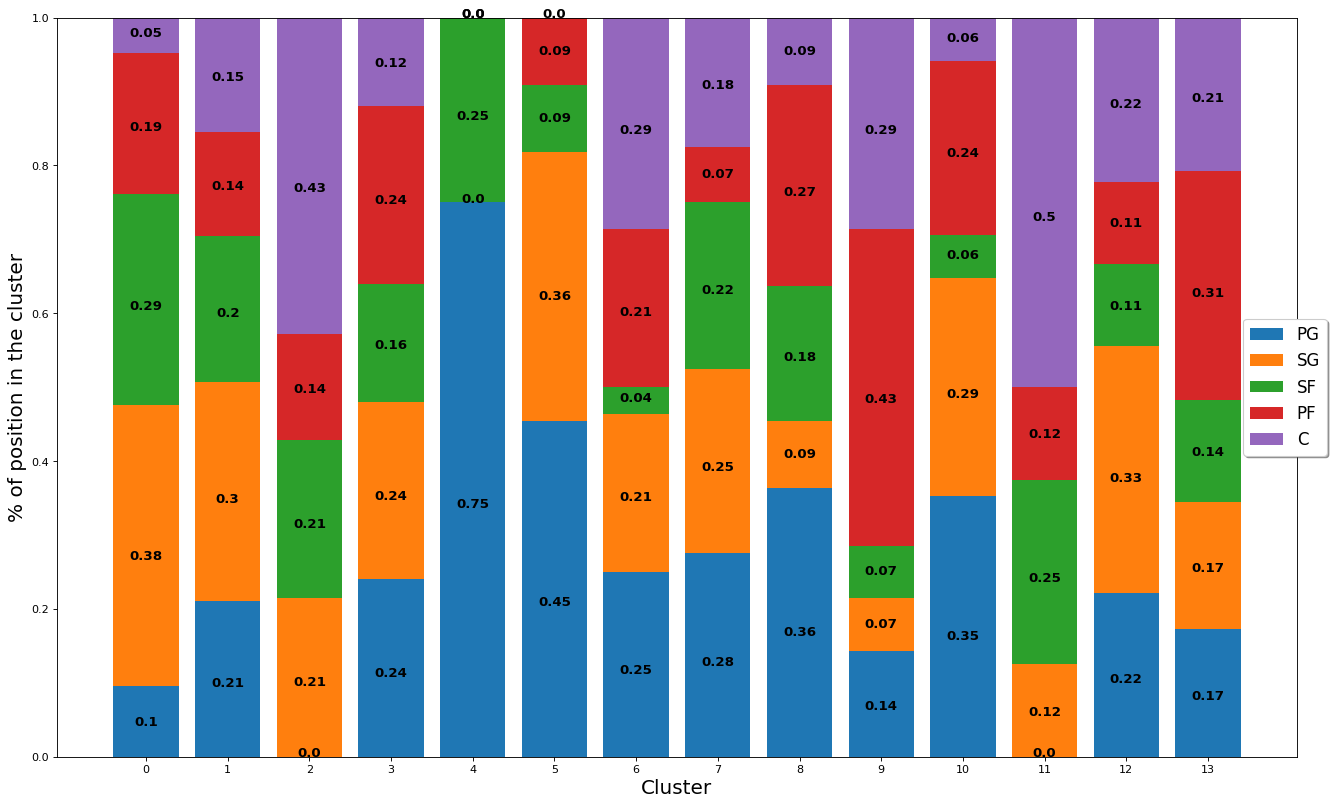

In [55]:
#2019
run_kmeans_per_season(2019)

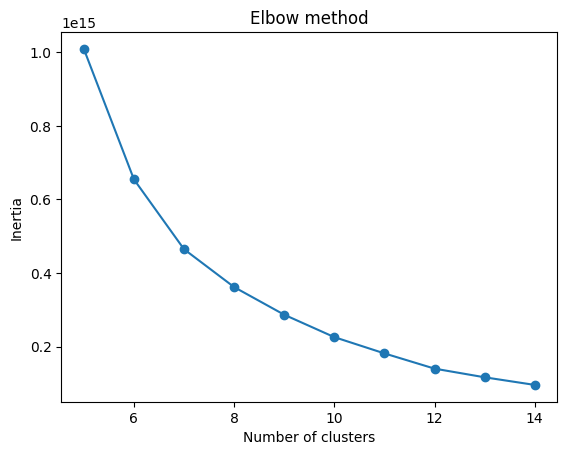

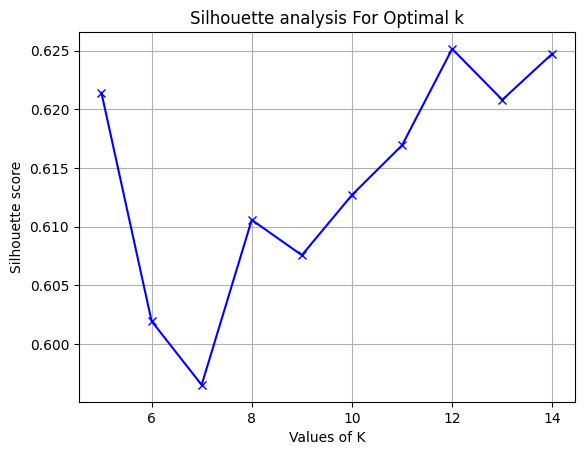

Cluster 0
                       Player
2         Delon Wright - 2020
15      Markelle Fultz - 2020
24        Jerami Grant - 2020
55           Ja Morant - 2020
59         T.J. Warren - 2020
63       Kyle Anderson - 2020
84          Tyus Jones - 2020
90   Spencer Dinwiddie - 2020
102         Lonzo Ball - 2020
120         Taj Gibson - 2020

Cluster 1
                     Player
16     Tobias Harris - 2020
65    Damian Lillard - 2020
119  Khris Middleton - 2020
150       Kyle Lowry - 2020
157     Jimmy Butler - 2020
170    Kawhi Leonard - 2020
183     Kemba Walker - 2020
205   Gordon Hayward - 2020
211     Paul Millsap - 2020
230      Paul George - 2020

Cluster 2
                    Player
1   Duncan Robinson - 2020
4     Dillon Brooks - 2020
7      Monte Morris - 2020
13   Furkan Korkmaz - 2020
20     Ben McLemore - 2020
21   Brad Wanamaker - 2020
26    Royce O'Neale - 2020
27  Anfernee Simons - 2020
28    Jarrett Allen - 2020
38    Dwight Howard - 2020

Cluster 3
                     P

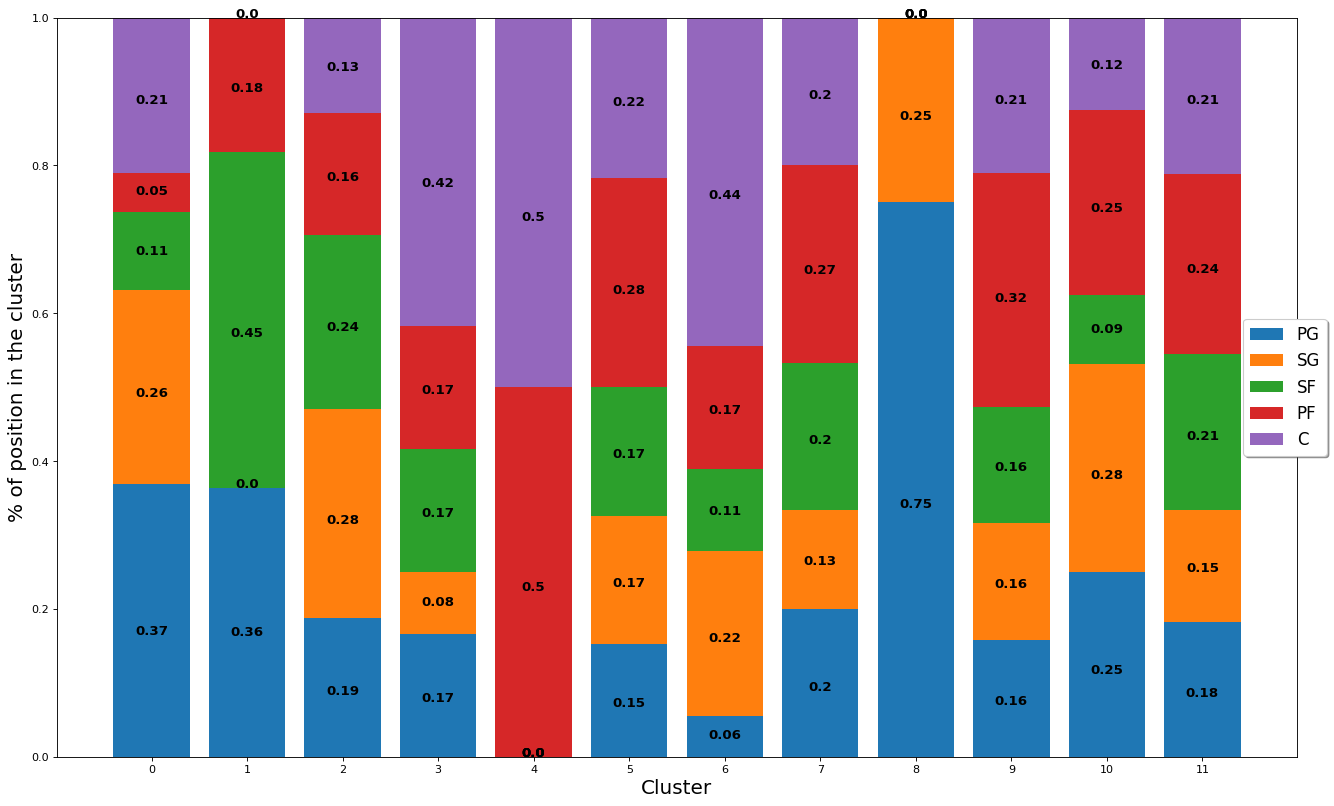

In [56]:
#2020
run_kmeans_per_season(2020)

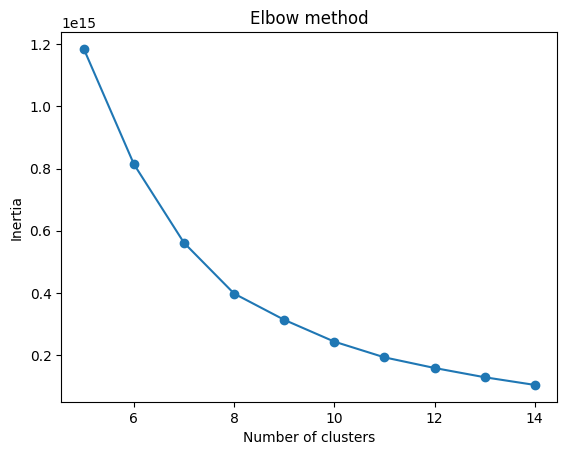

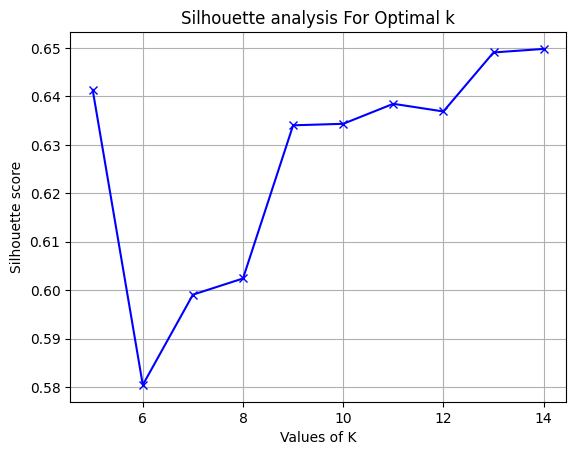

Cluster 0
                     Player
2      Mikal Bridges - 2021
20        Saddiq Bey - 2021
35    T.J. McConnell - 2021
37     Kevin Huerter - 2021
45        Kyle Kuzma - 2021
50    Isaiah Stewart - 2021
65  Donte DiVincenzo - 2021
66   Bismack Biyombo - 2021
69      Bobby Portis - 2021
72     Miles Bridges - 2021

Cluster 1
                           Player
17             Rudy Gobert - 2021
116          DeMar DeRozan - 2021
120         Brandon Ingram - 2021
121  Giannis Antetokounmpo - 2021
125           Bradley Beal - 2021
133           Jrue Holiday - 2021
218           Jamal Murray - 2021
240         Gordon Hayward - 2021
252       D'Angelo Russell - 2021

Cluster 2
                              Player
26                Brook Lopez - 2021
28           Robert Covington - 2021
43            Jordan Clarkson - 2021
51                Patty Mills - 2021
53             Thaddeus Young - 2021
60   Kentavious Caldwell-Pope - 2021
63              Dillon Brooks - 2021
167               Will B

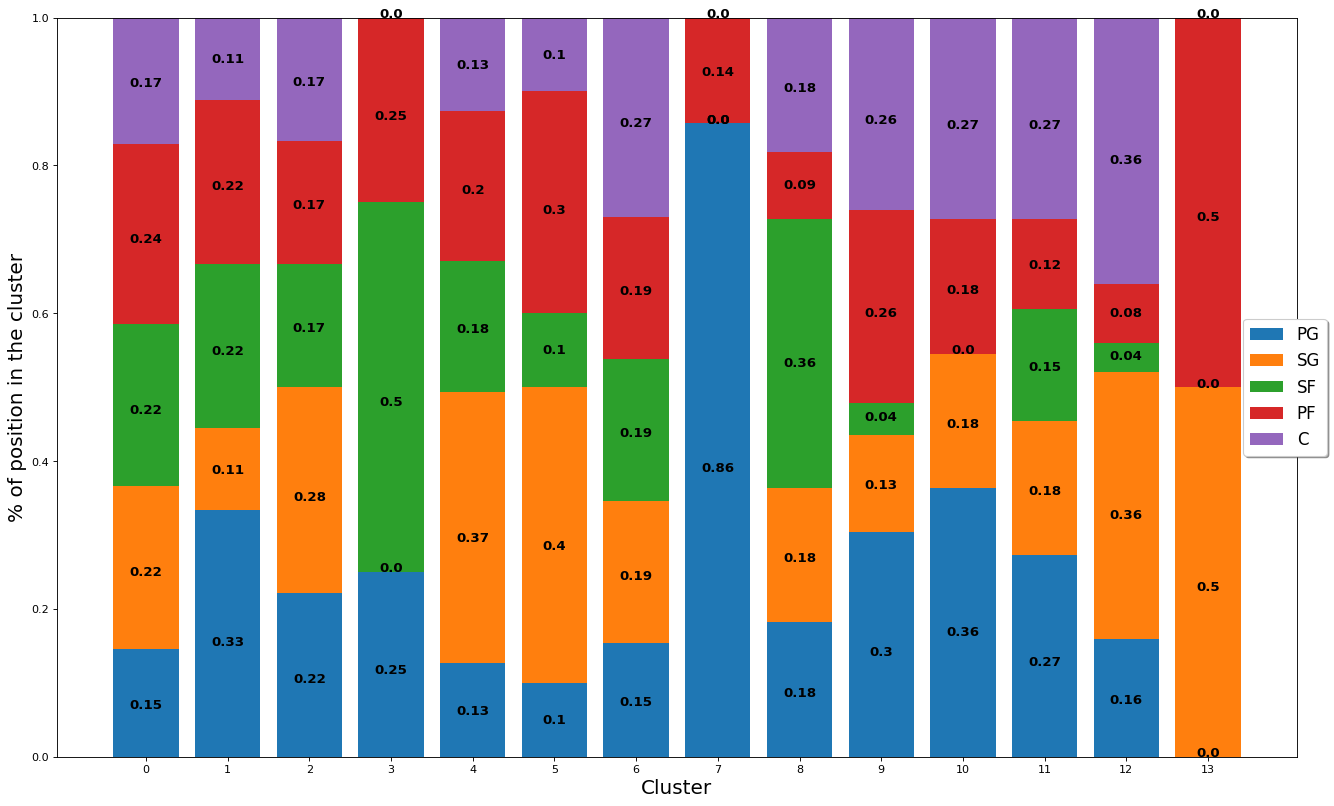

In [57]:
#2021
run_kmeans_per_season(2021)

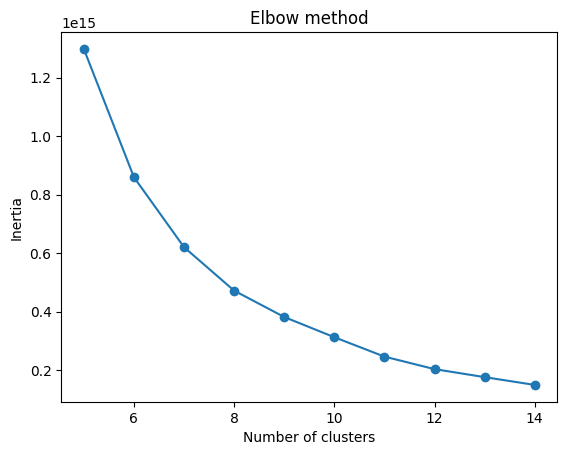

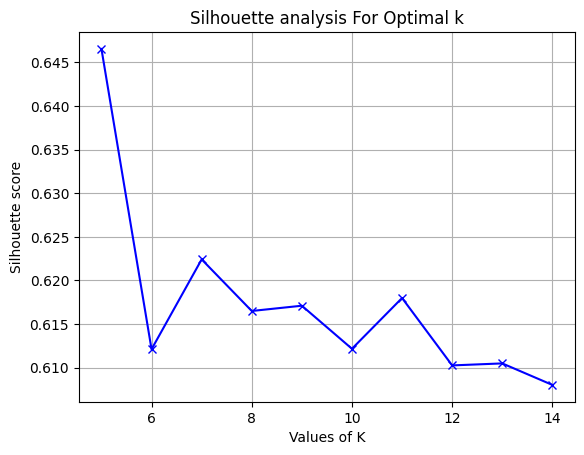

Cluster 0
                             Player
0              Dwight Powell - 2022
7                 Alec Burks - 2022
10             Chris Boucher - 2022
13           Jordan Clarkson - 2022
18         Jaren Jackson Jr. - 2022
23  Kentavious Caldwell-Pope - 2022
28              Delon Wright - 2022
29             Royce O'Neale - 2022
30           Devonte' Graham - 2022
34                Trae Young - 2022

Cluster 1
                        Player
31        DeMar DeRozan - 2022
32         Jayson Tatum - 2022
53   Karl-Anthony Towns - 2022
55           Kevin Love - 2022
65       Andrew Wiggins - 2022
96           Al Horford - 2022
110       Pascal Siakam - 2022
111        Devin Booker - 2022
112         Joel Embiid - 2022
121    Donovan Mitchell - 2022

Cluster 2
                        Player
1         Mikal Bridges - 2022
2            Saddiq Bey - 2022
3          Kevon Looney - 2022
4           Deni Avdija - 2022
5          Terance Mann - 2022
6           Patty Mills - 2022
8   Dorian Fin

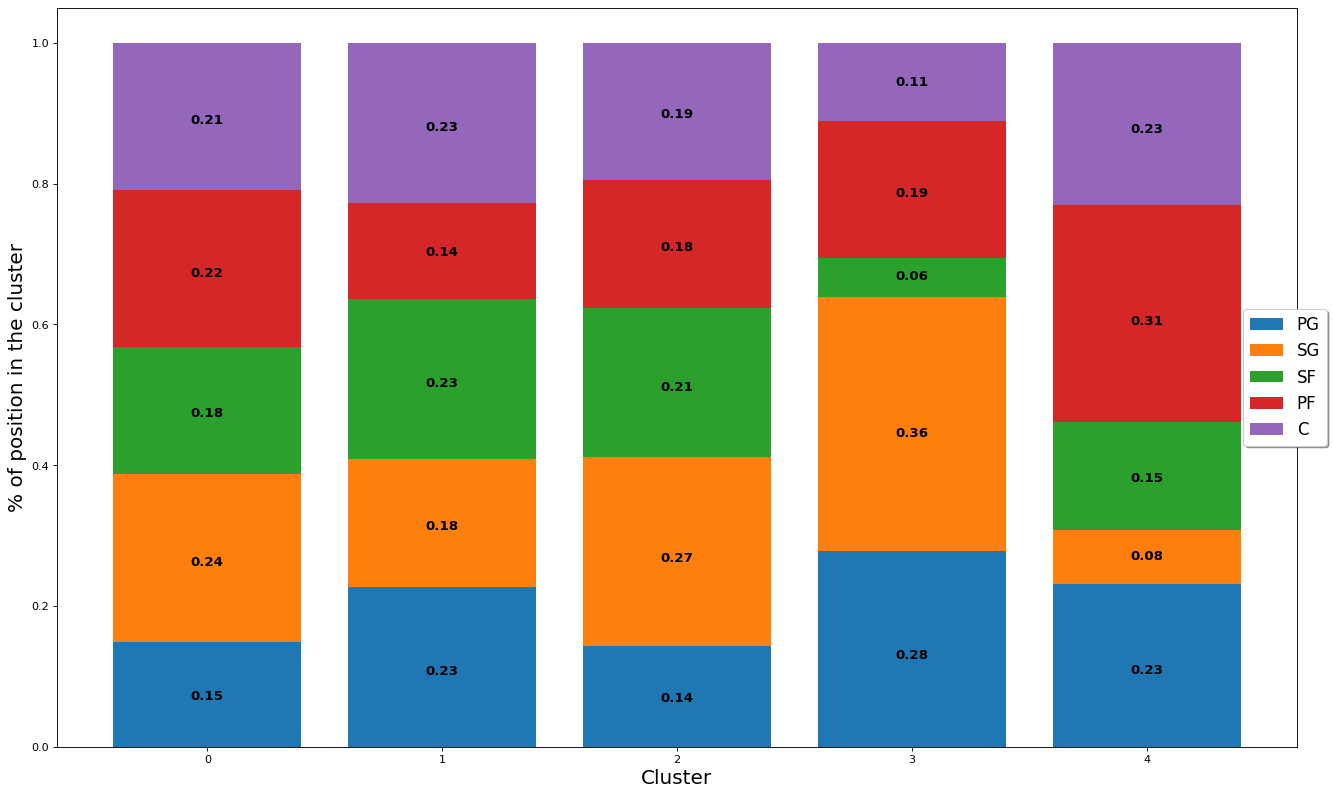

In [58]:
#2022
run_kmeans_per_season(2022)